In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Setting Matplotlib defaults
plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(8,5), dpi=150)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')
plt.tight_layout()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 500)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/calories-burnt-prediction/calories.csv
/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


<Figure size 1200x750 with 0 Axes>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv', index_col='id')
org = pd.read_csv('/kaggle/input/calories-burnt-prediction/calories.csv', index_col='User_ID')
org = org.rename(columns={'Gender': 'Sex'})

In [3]:
train = pd.concat([train, org], ignore_index=True)

In [4]:
strt_cols = list(test.columns)
print(train.drop_duplicates(subset=strt_cols + ['Calories']).shape, train.shape)

(762107, 8) (765000, 8)


In [5]:
org.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
User_ID,,,,,,,,
14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


# Data Understanding

In [6]:
test.shape

(250000, 7)

In [7]:
train.head(10)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
5,female,26,156.0,56.0,19.0,100.0,40.5,103.0
6,female,21,172.0,73.0,3.0,81.0,38.3,9.0
7,male,46,188.0,94.0,23.0,100.0,40.8,145.0
8,female,33,166.0,63.0,25.0,107.0,40.5,161.0
9,male,65,185.0,88.0,23.0,104.0,41.0,185.0


In [8]:
train.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000
mean,41.447255,174.693126,75.142162,15.423163,95.484672,40.036041,88.307424
std,15.213677,12.854173,14.004122,8.353421,9.452476,0.779863,62.396760
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [9]:
train.isnull().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [10]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 765000 entries, 0 to 764999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Sex         765000 non-null  object
 1   Age         765000 non-null  int64
 2   Height      765000 non-null  float64
 3   Weight      765000 non-null  float64
 4   Duration    765000 non-null  float64
 5   Heart_Rate  765000 non-null  float64
 6   Body_Temp   765000 non-null  float64
 7   Calories    765000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 47.4+ MB


# Data Preprocessing

## Reducing memory usage

In [11]:
train['Sex'] = train['Sex'].astype('category')
test['Sex'] = test['Sex'].astype('category')

In [12]:
train['Age'] = train['Age'].astype('int8')
test['Age'] = test['Age'].astype('int8')

In [13]:
num_cols = test.select_dtypes(include='float64').columns
for col in num_cols:
    train[num_cols] = train[num_cols].astype('float32')
    test[num_cols] = test[num_cols].astype('float32')

In [14]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 765000 entries, 0 to 764999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Sex         765000 non-null  category
 1   Age         765000 non-null  int8
 2   Height      765000 non-null  float32
 3   Weight      765000 non-null  float32
 4   Duration    765000 non-null  float32
 5   Heart_Rate  765000 non-null  float32
 6   Body_Temp   765000 non-null  float32
 7   Calories    765000 non-null  float64
dtypes: category(1), float32(5), float64(1), int8(1)
memory usage: 21.9 MB


# Feature Understanding via Data Visualization

Text(0.5, 1.0, 'Calories Distribution')

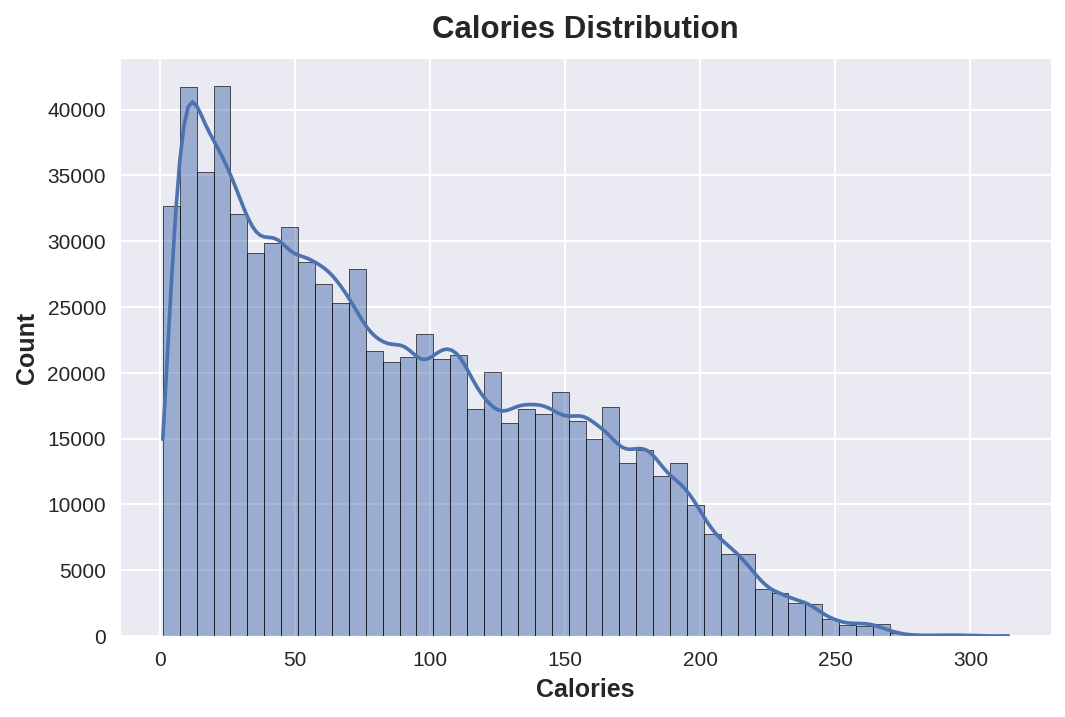

In [15]:
sns.histplot(x='Calories', bins=50, data=train, kde=True)
plt.title("Calories Distribution")

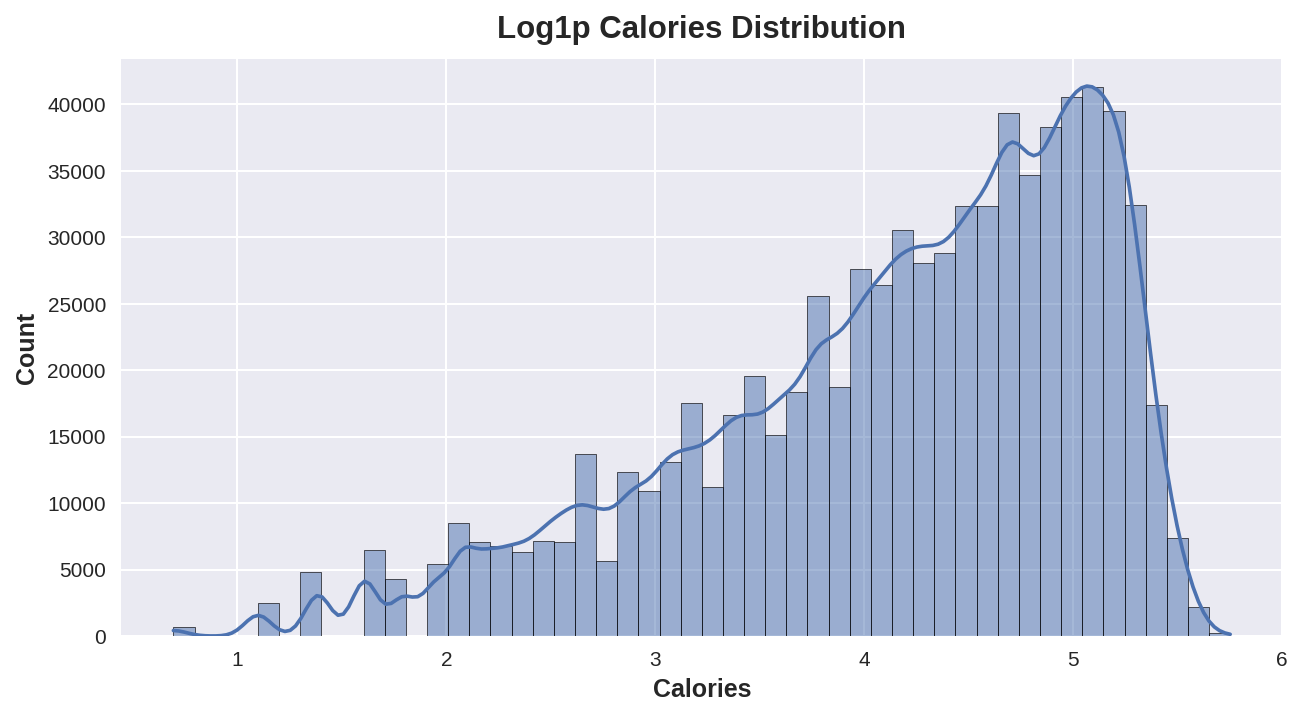

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(train["Calories"]), bins=50, kde=True)
plt.title("Log1p Calories Distribution")
plt.show()

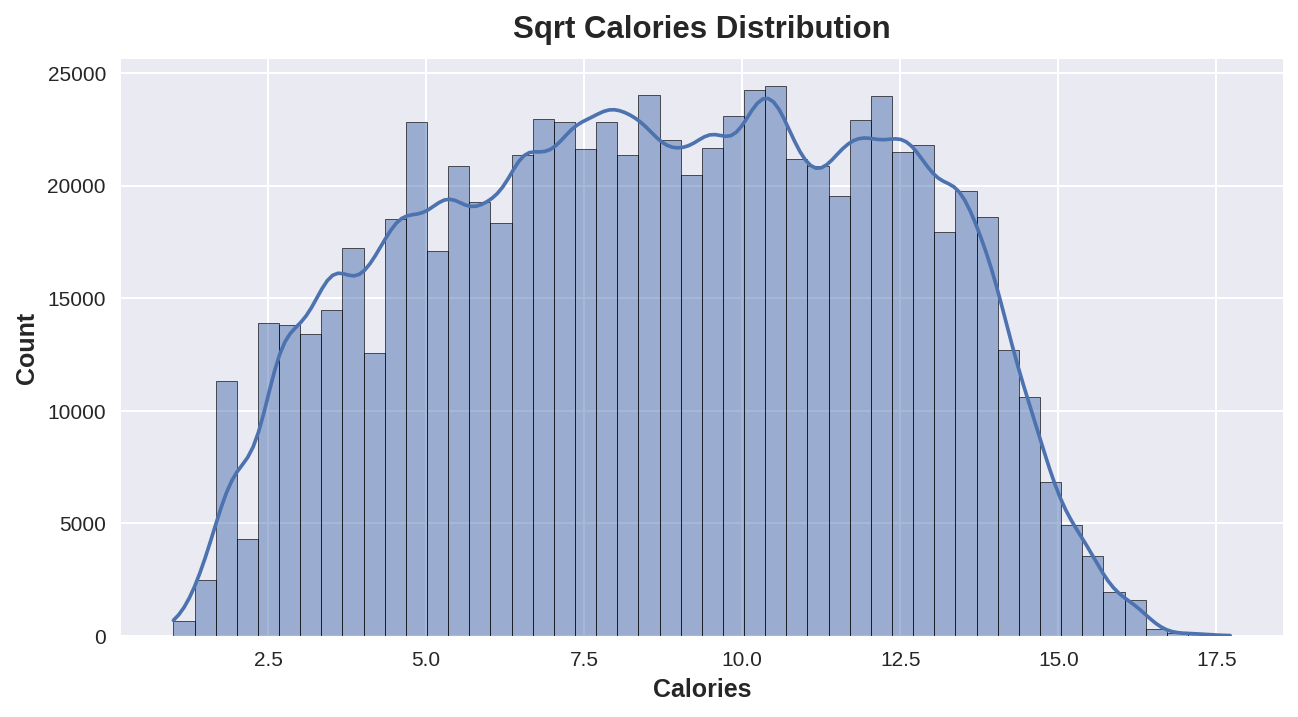

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(np.sqrt(train["Calories"]), bins=50, kde=True)
plt.title("Sqrt Calories Distribution")
plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex']).astype('int8')
test['Sex'] = le.transform(test['Sex']).astype('int8')

In [19]:
from sklearn.preprocessing import KBinsDiscretizer

kmeans = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
train['age_bins'] = kmeans.fit_transform(train[['Age']])
test['age_bins'] = kmeans.transform(test[['Age']])

In [20]:
train['BMI'] = train['Weight'] / ((train['Height']/100) ** 2)
test['BMI'] = test['Weight'] / ((test['Height']/100) ** 2)

In [21]:
features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI']

In [22]:
def add_features(df):
    for i, c1 in enumerate(features):
        for c2 in (features[i+1:]):
            m = f'{c1}*{c2}'
            df[m] = df[c1] * df[c2]
    return df

In [23]:
def feature_transform(df):
    df['duration_expo'] = df['Duration'] ** 2
    df['duration_log'] = np.log1p(df['Duration'])

    df['heart_expo'] = df['Heart_Rate'] ** 2
    df['heart_log'] = np.log1p(df['Heart_Rate'])
    
    df['body_expo'] = df['Body_Temp'] ** 2
    df['body_log'] = np.log1p(df['Body_Temp'] ** 2)
    
    return df

In [24]:
X = train.copy()
y = X.pop('Calories')
y = np.log1p(y)

#X = add_features(X)
#X = feature_transform(X)

X_test = test.copy()
#X_test = add_features(X_test)
#X_test = feature_transform(X_test)

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=100)

oof_xgb = np.zeros(len(y))
test_xgb = np.zeros(len(X_test))

stats = ['mean', 'median', 'max', 'min', 'std', 'skew', 'nunique']

for fold, (train_index, valid_index) in enumerate(kf.split(X, y), start=1):
        X_train, X_valid = X.iloc[train_index].copy(), X.iloc[valid_index].copy()
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        train_with_target = X_train.copy()
        train_with_target['Calories'] = y_train
        col = 'Duration'
    
        grouped_stats = train_with_target.groupby(col)['Calories'].agg(stats).reset_index().fillna(0.0)
        grouped_stats.columns = [col] + [f'TE1_WC_{stat}' for stat in stats]
    
        X_train = X_train.merge(grouped_stats, on=col, how='left').astype('float32')    
        X_valid = X_valid.merge(grouped_stats, on=col, how='left').astype('float32').fillna(0.0)
        
        X_test_fold = X_test.merge(grouped_stats, on=col, how='left').astype('float32').fillna(0.0)
        
        xgb = XGBRegressor(
            n_estimators=5000, 
            learning_rate=0.011297595542919868, 
            max_depth=8, 
            min_child_weight=10, 
            alpha=1.258508912794635, 
            reg_lambda=0.1743784996539347, 
            subsample=0.975503705730948, 
            colsample_bytree=0.501899569585645, 
            gamma=0.013828381261542193,
            early_stopping_rounds=50,
            tree_method='gpu_hist',
            device='cuda',
            seed= 100,
            objective='reg:squarederror', 
            eval_metric='rmse',
        ).fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    
        valid_pred = xgb.predict(X_valid)
        oof_xgb[valid_index] = valid_pred
        test_xgb += xgb.predict(X_test_fold) / n_folds
    
        fold_rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_valid), np.expm1(valid_pred)))
        print(f"Fold {fold} RMSE: {fold_rmsle:.6f}")

test_xgb = np.expm1(test_xgb)
test_xgb = np.clip(test_xgb, 1, 314)
overall_rmsle = np.sqrt(mean_squared_log_error(np.expm1(y), np.expm1(oof_xgb)))
print(f"\nOverall OOF RMSLE: {overall_rmsle:.6f}")   

Fold 1 RMSE: 0.058739
Fold 2 RMSE: 0.059058
Fold 3 RMSE: 0.059881
Fold 4 RMSE: 0.059844
Fold 5 RMSE: 0.059134

Overall OOF RMSLE: 0.059333


In [26]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
sub['Calories'] = test_xgb
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
print(sub.head(5))

Your submission was successfully saved!
       id    Calories
0  750000   27.554247
1  750001  107.838024
2  750002   87.516638
3  750003  125.872066
4  750004   75.864270
